# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
!pip install jupyter_contrib_nbextensions

     --------------------------------------- 20.9/20.9 MB 16.4 MB/s eta 0:00:00
     ------------------------------------- 467.2/467.2 kB 28.6 MB/s eta 0:00:00
     ------------------------------------- 861.7/861.7 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=bdfa0dace5d59c7f6952d98aa48b8fb2368c8a76e33c69cffeb3007c196d79b8
  Stored in directory: c:\users\sjohari\appdata\local\pip\cache\wheels\d2\b7\30\bc3a9af4b45a092df013e2b2e3eaa74e8dd05d6eb81263a8ca
Successfully built jupyter-latex-envs


In [4]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio as imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof


We set the random seed so that the results don't vary drastically.

In [56]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(20)

In [57]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [58]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

Reading folder names for training and validation. and setting the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10

Wall time: 10 ms


In [60]:
project_folder='Project_data'

## Plotting

In [61]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[0].grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    axes[0].minorticks_on()
    axes[0].grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].grid(b=True, color='aqua', alpha=0.6, linestyle='dashdot')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [62]:
class ModelBuilder(metaclass = abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self, image_height = 100, image_width = 100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparams(self, frames_to_sample = 30, batch_size = 20, num_epochs = 20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment = False):
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t,batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_seq = len(t) % batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq = 0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_len, self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imread.imread(source_path + '/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = cv2.resize(image, (self.image_height, self.image_width))
            

                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = cv2.resize(cropped, (self.image_height, self.image_width))
                    
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment = augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False, mode = 'auto', period = 1)
        LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs, verbose = 1, 
                            callbacks = callbacks_list, validation_data = val_generator, 
                            validation_steps = validation_steps, class_weight = None, workers = 1, initial_epoch = 0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [63]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape = (self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding ='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes, activation = 'softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        return model


In [64]:
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 40, num_epochs = 1)
conv_3d1_model = conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_25 (Activation)  (None, 15, 80, 80, 32)   

## Sample Cropping

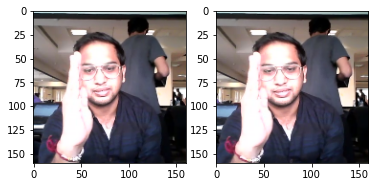

In [65]:
test_generator = ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height = 160, image_width = 160)
test_generator.initialize_hyperparams(frames_to_sample = 30, batch_size = 3, num_epochs = 1)

g=test_generator.generator(test_generator.val_path, test_generator.val_doc, augment = True)
batch_data, batch_labels = next(g)
fig, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].imshow(batch_data[0, 15, :, :, :])   
axes[1].imshow(batch_data[3, 15, :, :, :])  

## Experimenting with Image resolution, number of frames to use and batch_size

### 3D Convs Train Model 1 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 30, batch_size = 3, num_epochs = 1

In [67]:
%%time
conv_3d1.train_model(conv_3d1_model)

17/17 [==============================] - ETA: 0s - loss: 1.5490 - categorical_accuracy: 0.4344  
Epoch 1: saving model to model_init_2022-11-0917_15_19.457603\model-00001-1.54900-0.43439-1.81431-0.21000.h5
17/17 [==============================] - 2304s 137s/step - loss: 1.5490 - categorical_accuracy: 0.4344 - val_loss: 1.8143 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [68]:
print("Memory utilization is {} GBs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.6621095314621925 Gigs


## Following are the examples to see how training time is affected by image resolution, number of images in sequence and batch size

## 3D Convs Train Model 2 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 30, num_epochs = 3

In [69]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 30, num_epochs = 3)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5103 - categorical_accuracy: 0.4284  
Epoch 1: saving model to model_init_2022-11-0917_56_44.974030\model-00001-1.51034-0.42836-1.90498-0.33000.h5
23/23 [==============================] - 1902s 83s/step - loss: 1.5103 - categorical_accuracy: 0.4284 - val_loss: 1.9050 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.0497 - categorical_accuracy: 0.6094 
Epoch 2: saving model to model_init_2022-11-0917_56_44.974030\model-00002-1.04974-0.60935-3.83136-0.20000.h5
23/23 [==============================] - 1339s 57s/step - loss: 1.0497 - categorical_accuracy: 0.6094 - val_loss: 3.8314 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.7949 - categorical_accuracy: 0.6983 
Epoch 3: saving model to model_init_2022-11-0917_56_44.974030\model-00003-0.79489-0.69834-4.83131-0.210

### 3D Convs Train Model 3 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 30, batch_size = 30, num_epochs = 2

In [72]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 30, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5294 - categorical_accuracy: 0.4585 
Epoch 1: saving model to model_init_2022-11-0919_09_58.421971\model-00001-1.52943-0.45852-2.97076-0.16000.h5
23/23 [==============================] - 865s 38s/step - loss: 1.5294 - categorical_accuracy: 0.4585 - val_loss: 2.9708 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.9477 - categorical_accuracy: 0.6440 
Epoch 2: saving model to model_init_2022-11-0919_09_58.421971\model-00002-0.94774-0.64404-4.73297-0.14000.h5
23/23 [==============================] - 828s 35s/step - loss: 0.9477 - categorical_accuracy: 0.6440 - val_loss: 4.7330 - val_categorical_accuracy: 0.1400 - lr: 0.0010


### 3D Convs Train Model 4 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 30, batch_size = 60, num_epochs = 2

In [73]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 60, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6572 - categorical_accuracy: 0.4238 
Epoch 1: saving model to model_init_2022-11-0919_41_20.294778\model-00001-1.65719-0.42383-1.87875-0.16000.h5
12/12 [==============================] - 633s 52s/step - loss: 1.6572 - categorical_accuracy: 0.4238 - val_loss: 1.8787 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 0.9967 - categorical_accuracy: 0.6290 
Epoch 2: saving model to model_init_2022-11-0919_41_20.294778\model-00002-0.99666-0.62896-2.74046-0.15000.h5
12/12 [==============================] - 626s 52s/step - loss: 0.9967 - categorical_accuracy: 0.6290 - val_loss: 2.7405 - val_categorical_accuracy: 0.1500 - lr: 0.0010


### 3D Convs Train Model 5 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 60, num_epochs = 2

In [74]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 60, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.7496 - categorical_accuracy: 0.3816 
Epoch 1: saving model to model_init_2022-11-0920_03_59.601650\model-00001-1.74958-0.38160-1.71954-0.20000.h5
12/12 [==============================] - 327s 27s/step - loss: 1.7496 - categorical_accuracy: 0.3816 - val_loss: 1.7195 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1604 - categorical_accuracy: 0.5716 
Epoch 2: saving model to model_init_2022-11-0920_03_59.601650\model-00002-1.16043-0.57164-2.35632-0.17000.h5
12/12 [==============================] - 347s 29s/step - loss: 1.1604 - categorical_accuracy: 0.5716 - val_loss: 2.3563 - val_categorical_accuracy: 0.1700 - lr: 0.0010


### 3D Convs Train Model 6 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 80, num_epochs = 2

In [75]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 80, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.7394 - categorical_accuracy: 0.3514 
Epoch 1: saving model to model_init_2022-11-0920_15_27.280350\model-00001-1.73941-0.35143-1.64116-0.24000.h5
9/9 [==============================] - 386s 43s/step - loss: 1.7394 - categorical_accuracy: 0.3514 - val_loss: 1.6412 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 0.9996 - categorical_accuracy: 0.6259 
Epoch 2: saving model to model_init_2022-11-0920_15_27.280350\model-00002-0.99963-0.62594-1.79850-0.31000.h5
9/9 [==============================] - 390s 42s/step - loss: 0.9996 - categorical_accuracy: 0.6259 - val_loss: 1.7985 - val_categorical_accuracy: 0.3100 - lr: 0.0010


### 3D Convs Train Model 7 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 30, batch_size = 15, num_epochs = 2

In [76]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 15, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5474 - categorical_accuracy: 0.4419  
Epoch 1: saving model to model_init_2022-11-0920_28_37.511635\model-00001-1.54744-0.44193-5.74299-0.20000.h5
45/45 [==============================] - 3220s 72s/step - loss: 1.5474 - categorical_accuracy: 0.4419 - val_loss: 5.7430 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0109 - categorical_accuracy: 0.5973 
Epoch 2: saving model to model_init_2022-11-0920_28_37.511635\model-00002-1.01086-0.59729-9.74089-0.27000.h5
45/45 [==============================] - 1797s 38s/step - loss: 1.0109 - categorical_accuracy: 0.5973 - val_loss: 9.7409 - val_categorical_accuracy: 0.2700 - lr: 0.0010


### 3D Convs Train Model 8 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 15, num_epochs = 2

In [77]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 15,num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.3920 - categorical_accuracy: 0.4540 
Epoch 1: saving model to model_init_2022-11-0921_56_15.886175\model-00001-1.39198-0.45400-4.33518-0.16000.h5
45/45 [==============================] - 915s 20s/step - loss: 1.3920 - categorical_accuracy: 0.4540 - val_loss: 4.3352 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9523 - categorical_accuracy: 0.6305 
Epoch 2: saving model to model_init_2022-11-0921_56_15.886175\model-00002-0.95228-0.63047-5.22457-0.26000.h5
45/45 [==============================] - 925s 21s/step - loss: 0.9523 - categorical_accuracy: 0.6305 - val_loss: 5.2246 - val_categorical_accuracy: 0.2600 - lr: 0.0010


### 3D Convs Train Model 9 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 15, num_epochs = 2

In [78]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 15, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5107 - categorical_accuracy: 0.4510
Epoch 1: saving model to model_init_2022-11-0922_41_35.679289\model-00001-1.51075-0.45098-4.98244-0.22000.h5
45/45 [==============================] - 353s 8s/step - loss: 1.5107 - categorical_accuracy: 0.4510 - val_loss: 4.9824 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9611 - categorical_accuracy: 0.6561
Epoch 2: saving model to model_init_2022-11-0922_41_35.679289\model-00002-0.96108-0.65611-6.09488-0.22000.h5
45/45 [==============================] - 362s 8s/step - loss: 0.9611 - categorical_accuracy: 0.6561 - val_loss: 6.0949 - val_categorical_accuracy: 0.2200 - lr: 0.0010


### 3D Convs Train Model 10 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 16, batch_size = 10, num_epochs = 2

In [ ]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

### 3D Convs Train Model 11 
Size: Image Height = 100, Image Width = 100
frames_to_sample = 30, batch_size = 10, num_epochs = 2

In [ ]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 100, image_width = 100)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

### 3D Convs Train Model 12 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 30, batch_size = 10, num_epochs = 2

In [ ]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 30, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

### 3D Convs Train Model 13 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 10, num_epochs = 2

In [ ]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 10, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

### 3D Convs Train Model 14 
Size: Image Height = 160, Image Width = 160
frames_to_sample = 16, batch_size = 40, num_epochs = 2

In [ ]:
%%time
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height = 160, image_width = 160)
conv_3d1.initialize_hyperparams(frames_to_sample = 16, batch_size = 40, num_epochs = 2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

| **3D_CNN Model** | **Image Height** | **Image Width** | **Frame** | **batch** | **epochs** | **Parameters** | **Training Time** |
|---|---|---|---|---|---|---|---|
| **3D_CNN_1** | 160 | 160 | 30 | 3 | 1 | 1736389 | 1min 41s |
| **3D_CNN_2** | 160 | 160 | 16 | 30 | 3 | 1736389 | 2min 18s |
| **3D_CNN_3** | 100 | 100 | 30 | 30 | 2 | 687813 | 2min 14s |
| **3D_CNN_4** | 100 | 100 | 30 | 60 | 2 | 687813 | 2min 19s |
| **3D_CNN_5** | 100 | 100 | 16 | 60 | 2 | 687813 | 1mn 16s |
| **3D_CNN_6** | 100 | 100 | 16 | 80 | 2 | 687813 | 1min 18s |
| **3D_CNN_7** | 160 | 160 | 30 | 15 | 2 | 1736389 | 2min 46s |
| **3D_CNN_8** | 160 | 160 | 16 | 15 | 2 | 1736389 | 1min 31s |
| **3D_CNN_9** | 100 | 100 | 16 | 15 | 2 | 687813 | 1min 10s |
| **3D_CNN_10** | 100 | 100 | 16 | 10 | 2 | 687813 | 1min 10s |
| **3D_CNN_11** | 100 | 100 | 30 | 10 | 2 | 687813 | 2min 10s |
| **3D_CNN_12** | 160 | 160 | 30 | 10 | 2 | 1736389 | 2min 46s |
| **3D_CNN_13** | 160 | 160 | 16 | 10 | 2 | 1736389 | 1min 33s |
| **3D_CNN_14** | 160 | 160 | 16 | 40 | 2 | 1736389 | 1min 34s |

As per above experiments image resolution and number of frames in sequence have more impact on training time than batch_size.
So experimentations will be carried out with batch size fixed between 15-40 and changing the resolution and number of image per sequence based on the device memory constraints.

In [70]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


SyntaxError: invalid syntax (<ipython-input-70-bdb5e98e0481>, line 3)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = # choose the number of epochs
print ('# epochs =', num_epochs)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)